# Predicting Subscription to a Game-Related Newsletter Among Minecraft Players

## Introduction
**Background**: In 2023, the Pacific Laboratory for Artificial Intelligence at UBC launched plaicraft.ai, a generative AI research data collection project that collects data on players who play the video game Minecraft through their game server. This report will analyze some of the data collected on players from plaicraft.ai.

**Question**: Can a player’s age and number of hours played predict whether or not that player is subscribed to a game-related newsletter in players.csv?

**Data Description**: The players.csv dataset was used to answer the predictive question above. It contains 196 observations, each of which represents 1 player. For each observation there are 7 variables. The response variable of interest in this report is subscribe. Out of 196 observations, 52 of them (27%) are false while 144 of them (73%) are true for this variable.
| Variable Name | Type | Contents | Meaning | Issues |
|:--------:|:--------:|:--------:|:--------:|:--------:|
|  experience   |  character   |  one of the following: “Beginner”, “Amateur”, “Regular”, “Veteran”, “Pro”   |  the experience level of the player   |  it’s not required for this analysis, but this column could be converted into factors   |
|  subscribe   |  logical   |  either TRUE or FALSE   |  whether or not the player is subscribed to a game-related newsletter   |  -   |
|  hashedEmail   |  character   |  a unique string of characters, 64 characters long   |  the player’s email address encrypted as an unreadable code that’s difficult to revert to the original email address   |  the column name has a capital letter and doesn’t use an underscore; this isn’t really an issue but it doesn’t follow the typical naming convention   |
|  played_hours   |  double   |  a number rounded to the nearest tenth   |  the number of hours played   |  -   |
|  name   |  character   |  a string of characters   |  the player’s first name   |  -   |
|  gender   |  character   |  one of the following: “Male”, “Female”, “Two-Spirited”, “Non-binary”, “Prefer not to say”   |  the player’s gender   |  -   |
|  Age   |  double   |  a whole number   |  the player’s age   |  some rows have NA’s and also the column name has a capital letter; this isn’t really an issue but it doesn’t follow the typical naming convention   |


In [1]:
#loading libraries
library(tidyverse)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
#setting the seed
set.seed(3)

In [3]:
#reading the data
options(repr.matrix.max.rows = 6)

players <- read_csv("data/players.csv")
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


In [4]:
#exploring the data
num_obs <- nrow(players)

players |>
    group_by(subscribe) |>
    summarize(count = n(),
              percentage = (n()/num_obs)*100)

subscribe,count,percentage
<lgl>,<int>,<dbl>
FALSE,52,26.53061
TRUE,144,73.46939


In [5]:
# cleaning data
players_clean <- players |>
    rename(hashed_email = hashedEmail, age = Age) |>
    filter(!is.na(age)) |>
    mutate(subscribe = as_factor(subscribe)) |>
    mutate(subscribe = fct_recode(subscribe, "Yes" = "TRUE", "No" = "FALSE"))
players_clean

experience,subscribe,hashed_email,played_hours,name,gender,age
<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,Yes,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,Yes,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,No,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Veteran,No,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,No,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,No,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17


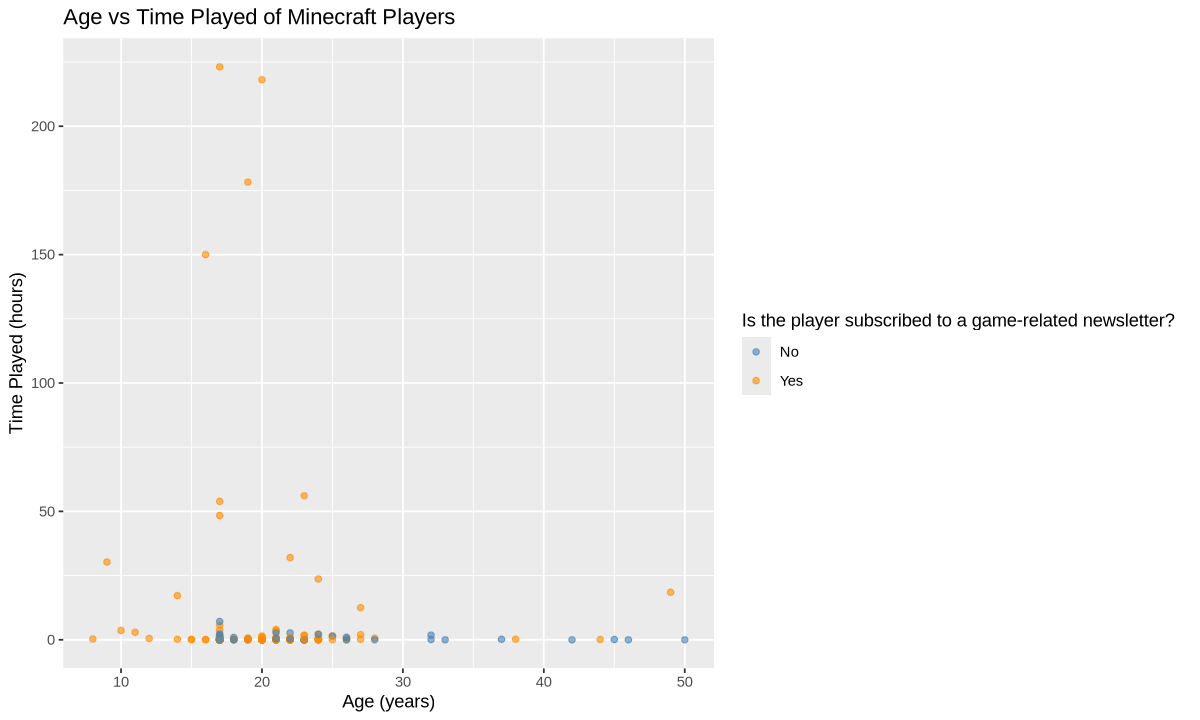

In [6]:
#visualizing data
options(repr.plot.height = 6, repr.plot.width = 10)

players_plot <- players_clean |>
    ggplot(aes(x = age, y = played_hours, color = subscribe)) +
    geom_point(alpha = 0.6) +
    ggtitle("Age vs Time Played of Minecraft Players") +
    labs(x = "Age (years)",
         y = "Time Played (hours)",
         color = "Is the player subscribed to a game-related newsletter?") +
    scale_color_manual(values = c("steelblue", "darkorange"))
players_plot

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5102041


          Truth
Prediction No Yes
       No   3  14
       Yes 10  22

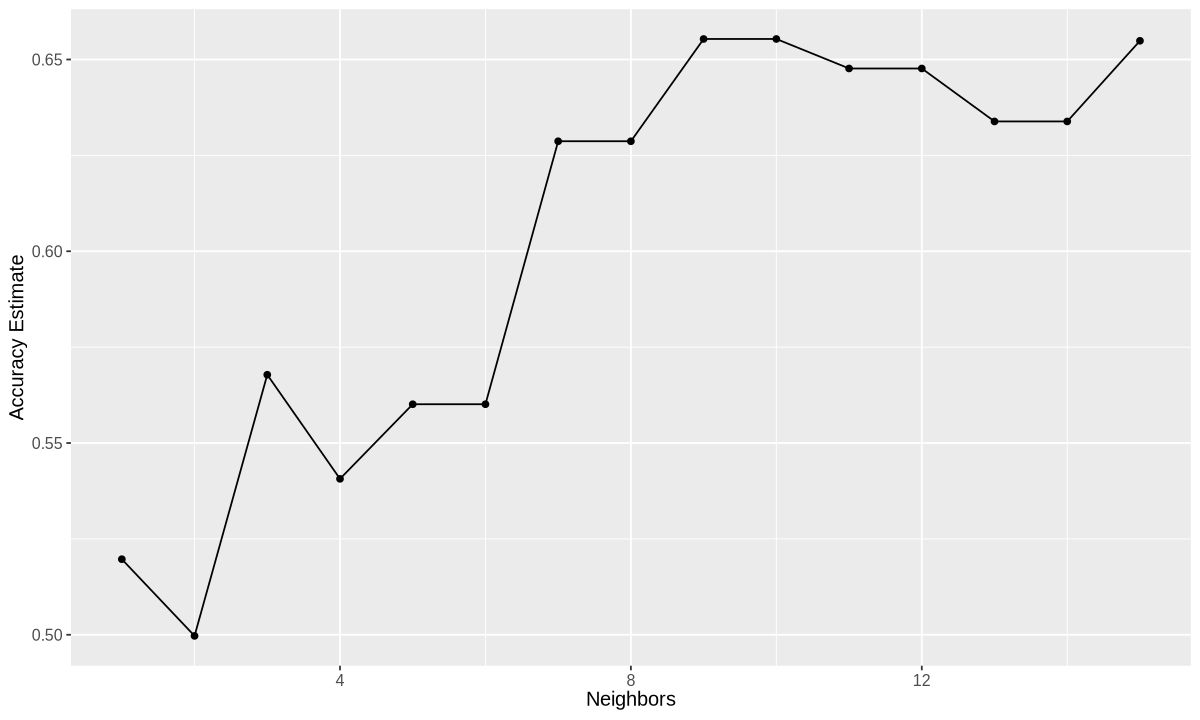

In [7]:
#classification
players_split <- initial_split(players_clean, prop = 0.75, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

players_recipe <- recipe(subscribe ~ age + played_hours, data = players_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

players_vfold_10 <- vfold_cv(players_train, v = 10, strata = subscribe)

k_vals <- tibble(neighbors = 1:15)

accuracies <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = players_vfold_10, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 12))
accuracy_vs_k

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 10) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec) |>
    fit(data = players_train)

players_test_predictions <- knn_fit |>
    predict(players_test) |>
    bind_cols(players_test)

accuracy <- players_test_predictions |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")
accuracy

confusion <- players_test_predictions |>
    conf_mat(truth = subscribe, estimate = .pred_class)
confusion